In [1]:
import torch
from torchsummary import summary
from torch import nn
from torch.utils.data import TensorDataset,Dataset,DataLoader
from torch.optim import SGD, Adam
from torchvision import datasets
import numpy as np, cv2
import matplotlib.pyplot as plt
from glob import glob
from imgaug import augmenters as iaa

C:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Asus\AppData\Local\Programs\Python\Python38\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


# Global variables

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Fetching the data

In [3]:
tfm = iaa.Sequential(iaa.Resize(28))

In [4]:
class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self):
        return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:, :, 0])
        im = im[None] # add a dummy channel dimension at the beginning
        cl = f.split('\\')[-1].split('@')[0] == 'x' # class
        return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

We have not used `collate_fn` because this is a small dataset and wouldn't affect the training time.

In [5]:
data = XO('all/*')

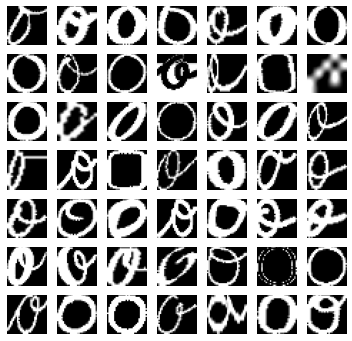

In [6]:
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im, label = data[ix]
        plot_cell.imshow(im[0].cpu(), cmap='gray')
        plt.tight_layout()

# Defining the model

In [7]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)
    
    loss_function = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_function, optimizer

In [8]:
model, loss_function, optimizer = get_model()
summary(model, torch.zeros(1, 1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 1]                   257
├─Sigmoid: 1-11                          [-1, 1]                   --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass s

# Training the model

In [9]:
def train_batch(x, y, model, optimizer, loss_function):
    model.train()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    batch_loss = loss_function(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct[0]

In [10]:
train_dataloader = DataLoader(XO('all/*'), batch_size=32, drop_last=True)

In [11]:
for epoch in range(5):
    for batch in train_dataloader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)

# Visualize filters

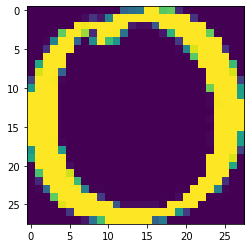

In [12]:
im, c = train_dataloader.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

In [13]:
list(model.children())[:1]

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))]

In [14]:
first_layer = nn.Sequential(list(model.children())[0])
intermediate_output = first_layer(im[None])[0].detach()

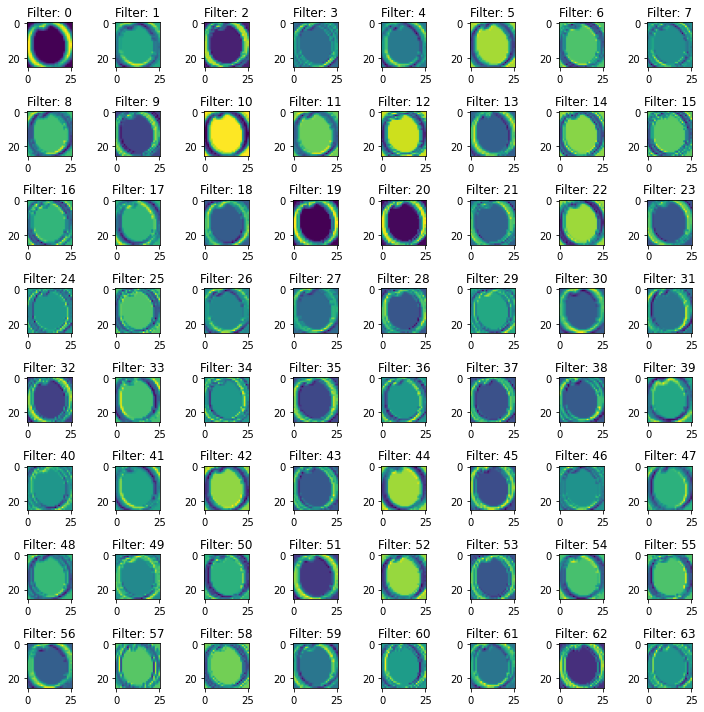

In [15]:
fig, ax = plt.subplots(8, 8, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.set_title(f"Filter: {ix}")
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

# Illustrating multiple 'O' images

In [16]:
x, y = next(iter(train_dataloader))
x2 = x[y == 0]

In [17]:
x2 = x2.view(-1, 1, 28, 28)

In [18]:
first_layer_output = first_layer(x2).detach()

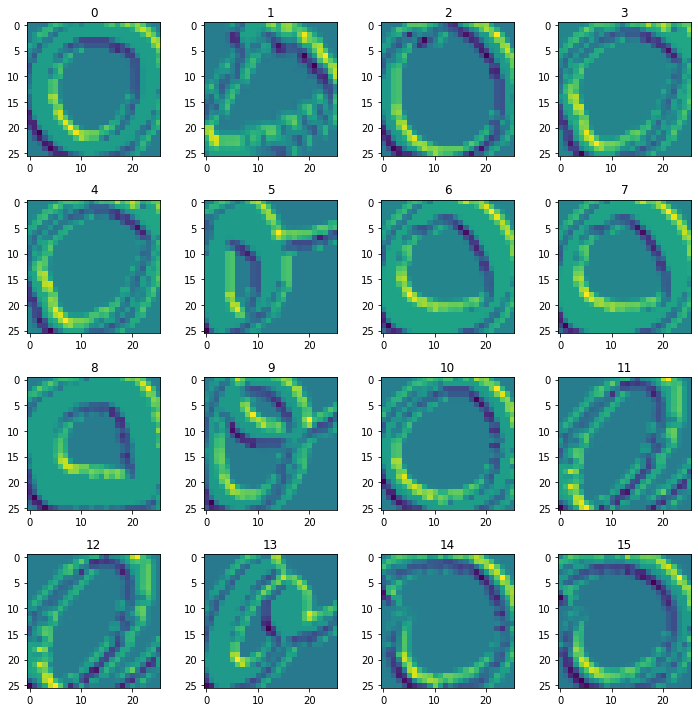

In [19]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(first_layer_output[ix, 4, :, :].cpu()) # 4st filter
    axis.set_title(f"{ix}")
plt.tight_layout()

**Note**: the behavior of given filter has remained constant across images.

# Visualizing output of second conv layer

In [20]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

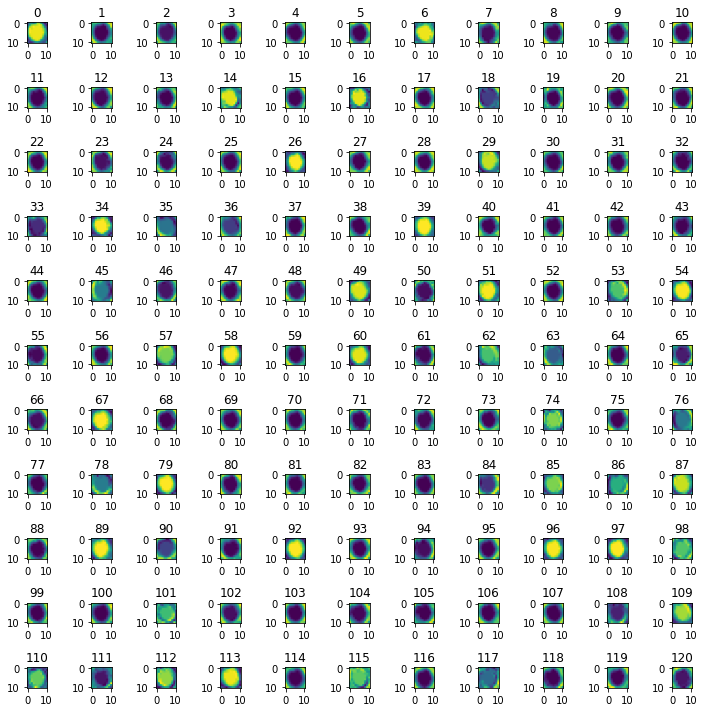

In [21]:
fig, ax = plt.subplots(11, 11, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(f"{ix}")
plt.tight_layout()

# Illustrating multiple 'O' images for second conv layer

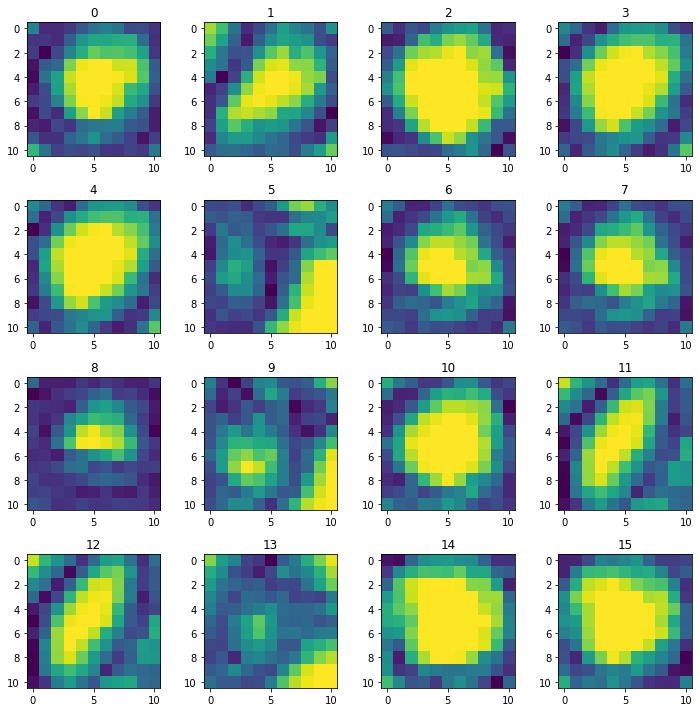

In [22]:
second_intermediate_output = second_layer(x2).detach()
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix, 34, :, :].cpu())
    axis.set_title(f"{ix}")
plt.tight_layout()

# Plot the activations of fully connection layer

In [23]:
custom_dl = DataLoader(XO('all/*'), batch_size=2498, drop_last=True)

In [24]:
x, y = next(iter(custom_dl))
x2 = x[y == 0]
x2 = x2.view(len(x2), 1, 28, 28)

In [25]:
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

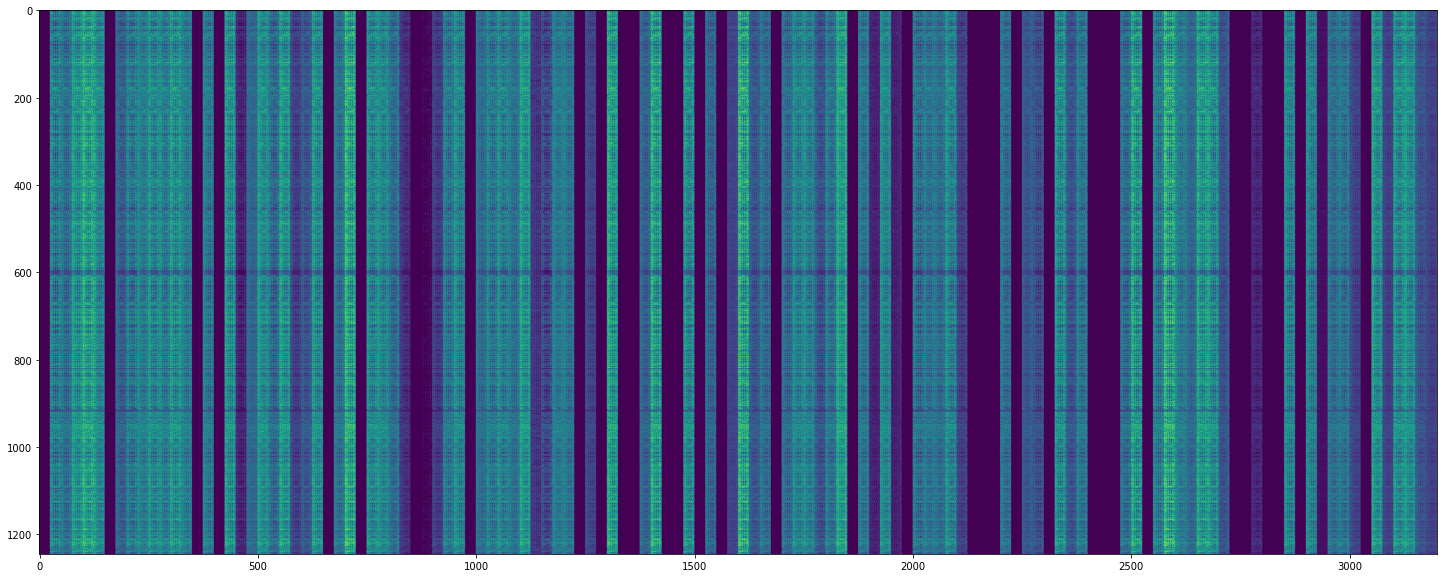

In [26]:
plt.figure(figsize=(100, 10))
plt.imshow(flatten_layer_output.cpu());

**Note that the model has learned to bring some structure to the fully connected layer, even though the input images – while all belonging to the same class – differ in style considerably.**